In [1]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from ipywidgets import interact
import ipywidgets as widgets

from my_tools import *

# %matplotlib widget

# plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # 中文字体设置
# plt.rcParams['axes.unicode_minus'] = False  # 负号显示设置

## 训练集

训练集共 10 种已知调制信号序列样本（ID 映射关系具体如下：1：BPSK，2：QPSK，3：8PSK，4：MSK，5：8QAM，6：16-QAM，7：32-QAM，8：8-APSK，9：16-APSK，10：32-APSK， _11：未知_），信号产生过程涵盖了不同的信号长度、大范围脉宽、不同码元宽度，并模拟了不同信噪比 SNR 条件及多径、衰落等干扰环境，序列样本的答案为==调制类型==、==码元宽度==以及==调制码序列==。

训练数据设置信号的采样率为 20MHz，共包含 10 个文件夹，每个文件夹有 1.8W 种不同的信号长度、码元宽度、SNR 及多径的样本数据，数据格式为 csv 文件，其中

`调制类型/data_i.csv`

- 第一二列分别为仿真 IQ 波形，
- 第三列是仿真码序列，
- 第四列为仿真调制类型，
- 第五列为仿真码元宽度。

训练集数据样例

```csv
I,Q,code_sequence,mod_type,symbol_width
```

```csv
0.116968457,-0.116234822,1,8,0.3
0.040505204,-0.052175848,2,,
0.057982783,-0.022685991,4,,
...
-0.063333339,-0.406944517,1,,
0.310174569,-0.296002185,0,,
0.03098683,-0.021350515,,,
-0.217157376,0.133123255,,,
...
0.284242879,-0.410904562,,,
0.387534338,-0.115390908,,,
```

**各调制类型的比较表**

| 调制类型   | 星座点分布     | 每符号比特数 |
| ---------- | -------------- | ------------ |
| **BPSK**   | 2点，相位对立  | 1            |
| **QPSK**   | 4点，相位均匀  | 2            |
| **8PSK**   | 8点，相位均匀  | 3            |
| **MSK**    | 圆周，连续相位 | 2            |
| **8QAM**   | 网格状点分布   | 3            |
| **16QAM**  | 网格状点分布   | 4            |
| **32QAM**  | 网格状点分布   | 5            |
| **8APSK**  | 2圈同心圆分布  | 3            |
| **16APSK** | 3圈同心圆分布  | 4            |
| **32APSK** | 3圈同心圆分布  | 5            |


In [2]:
class EBDSC3rdDataset(Dataset):
    # 1：BPSK，2：QPSK，3：8PSK，4：MSK，5：8QAM，6：16-QAM，7：32-QAM，8：8-APSK，9：16-APSK，10：32-APSK， 11：UNKNOWN
    MOD_TYPE = dict(
        zip(
            range(1, 12),
            ["BPSK", "QPSK", "8PSK", "MSK", "8QAM", "16QAM", "32QAM", "8APSK", "16APSK", "32APSK", "UNKNOWN"],
        )
    )
    DATA_COLUMNS = ["I", "Q", "code_sequence", "mod_type", "symbol_width"]

    # 码元宽度的单位与 IQ 单位差 20 倍
    SYMBOL_WIDTH_UNIT = 20

    def __init__(self, root_dir):
        self.samples = []
        for label in range(1, 11):
            folder_path = os.path.join(root_dir, self.MOD_TYPE[label])
            if os.path.isdir(folder_path):
                files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]
                for csv_file in files:
                    self.samples.append(csv_file)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        df = pd.read_csv(file_path, names=self.DATA_COLUMNS, header=None)
        IQ_data = df[["I", "Q"]].to_numpy().astype(np.float32)
        code_sequence = df["code_sequence"].dropna().astype(int).to_numpy().astype(np.int32)
        mod_type = int(df["mod_type"][0])
        symbol_width = float(df["symbol_width"][0])
        return IQ_data, code_sequence, mod_type, symbol_width


# 用 DataLoader 打包训练数据
root_dir = "../train_data/"  # 替换为实际路径
train_dataset = EBDSC3rdDataset(root_dir)

In [3]:
# 参数分布
IQ_data_lens = []
mod_types = []
symbol_widths = []
code_sequence_lens = []
symbol_count = [0] * 32
symbol_by_modtype = [set() for _ in range(11)]
carrier_freqs = []


def process_batch(batch):
    local_IQ_data_lens = []
    local_mod_types = []
    local_symbol_widths = []
    local_code_sequence_lens = []
    local_symbol_count = [0] * 32
    local_symbol_by_modtype = [set() for _ in range(11)]
    local_carrier_freqs = []

    for i in batch:
        iq_data, code_sequence, mod_type, symbol_width = train_dataset[i]
        local_IQ_data_lens.append(len(iq_data))
        local_mod_types.append(mod_type)
        local_symbol_widths.append(symbol_width)
        local_code_sequence_lens.append(len(code_sequence))

        # iq_filtered = (iq_data - np.mean(iq_data, axis=0)) / np.std(iq_data, axis=0)
        iq_filtered = iq_data
        iq_complex = iq_filtered[:, 0] + 1j * iq_filtered[:, 1]
        f, _ = compute_topk_freqs(iq_complex, 1)
        local_carrier_freqs.extend(f.tolist())

        for code in code_sequence:
            local_symbol_count[code] += 1
            local_symbol_by_modtype[mod_type - 1].add(int(code))

    return (
        local_IQ_data_lens,
        local_mod_types,
        local_symbol_widths,
        local_code_sequence_lens,
        local_symbol_count,
        local_symbol_by_modtype,
        local_carrier_freqs,
    )


batch_size = 1000
batches = [range(i, min(i + batch_size, len(train_dataset))) for i in range(0, len(train_dataset), batch_size)]

results = Parallel(n_jobs=-1)(delayed(process_batch)(batch) for batch in tqdm(batches))

for result in results:
    IQ_data_lens.extend(result[0])
    mod_types.extend(result[1])
    symbol_widths.extend(result[2])
    code_sequence_lens.extend(result[3])
    for i in range(32):
        symbol_count[i] += result[4][i]
    for i in range(11):
        symbol_by_modtype[i].update(result[5][i])
    carrier_freqs.extend(result[6])

IQ_data_lens, mod_types, symbol_widths, code_sequence_lens = map(
    np.array, [IQ_data_lens, mod_types, symbol_widths, code_sequence_lens]
)
carrier_freqs = np.array(carrier_freqs)

100%|██████████| 180/180 [00:48<00:00,  3.72it/s]


In [4]:
print(f"{symbol_count=}")

for i in range(11):
    print(f"{EBDSC3rdDataset.MOD_TYPE[i+1]}: {symbol_by_modtype[i]}")

print(repr(symbol_by_modtype))

nums = [len(s) for s in symbol_by_modtype]
s = [sum(nums[:i]) for i in range(len(nums))]
print(s)

s = 0
for i in range(11):
    print(f"{EBDSC3rdDataset.MOD_TYPE[i+1]}: {s}")
    s += nums[i]


print(f"{set(mod_types.tolist())=}")
print(f"{set(symbol_widths.tolist())=}")
symbol_widths_absl = symbol_widths * EBDSC3rdDataset.SYMBOL_WIDTH_UNIT
print(f"{np.unique(symbol_widths_absl)=}")
# {5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0}


residuals = (symbol_widths_absl * code_sequence_lens - IQ_data_lens) / symbol_widths_absl
# 平均数，中位数
print(f"{np.mean(residuals) =}, {np.median(residuals) =}")
print(f"abs residual > 1 ratio: {np.sum(np.abs(residuals) > 1) / len(residuals)}")

# 基带信号与带通信号的比例
print(f"基带信号与带通信号的比例 {(carrier_freqs < 1 / symbol_widths_absl).sum() / len(carrier_freqs)=}")
print(f"基带信号与带通信号的比例 (严格) {(carrier_freqs < 1 / symbol_widths_absl / 2).sum() / len(carrier_freqs)=}")

symbol_count=[3243727, 3246386, 1456256, 1454940, 1006935, 1007130, 1008265, 1009025, 336426, 335218, 335189, 335085, 335247, 335980, 336053, 334833, 112483, 112093, 111919, 111949, 111947, 111612, 111753, 112019, 111637, 111972, 112310, 111744, 111928, 112673, 111772, 111938]
BPSK: {0, 1}
QPSK: {0, 1, 2, 3}
8PSK: {0, 1, 2, 3, 4, 5, 6, 7}
MSK: {0, 1}
8QAM: {0, 1, 2, 3, 4, 5, 6, 7}
16QAM: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
32QAM: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
8APSK: {0, 1, 2, 3, 4, 5, 6, 7}
16APSK: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
32APSK: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
UNKNOWN: set()
[{0, 1}, {0, 1, 2, 3}, {0, 1, 2, 3, 4, 5, 6, 7}, {0, 1}, {0, 1, 2, 3, 4, 5, 6, 7}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

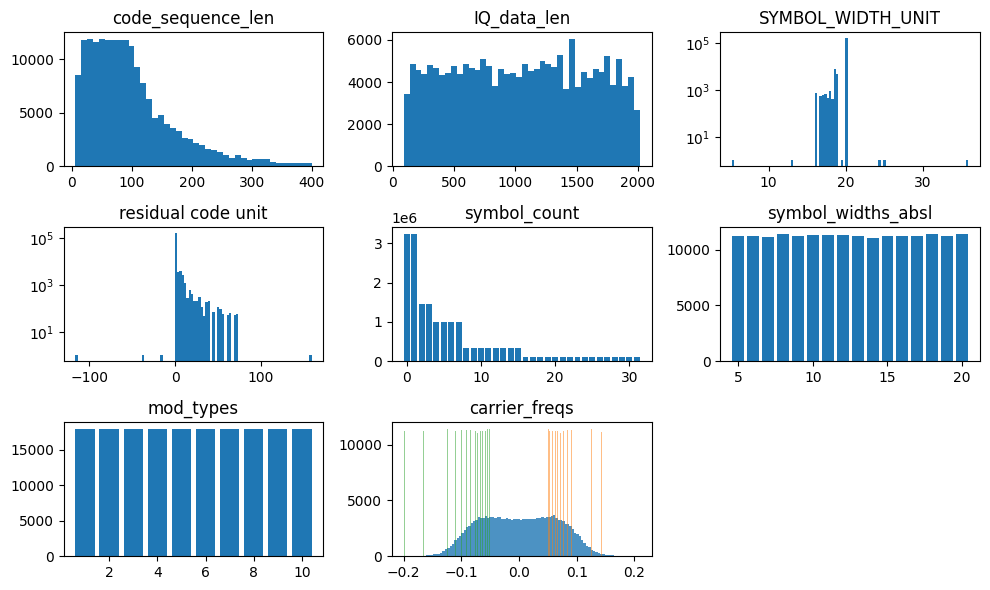

In [5]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 3, 1)
plt.hist(code_sequence_lens, bins=40)
plt.title("code_sequence_len")
plt.subplot(3, 3, 2)
plt.hist(IQ_data_lens, bins=40)
plt.title("IQ_data_len")

#  len(IQ_data) / (len(code_sequence) * symbol_width)
plt.subplot(3, 3, 3)
plt.hist(IQ_data_lens / code_sequence_lens / symbol_widths, bins=100)
# y log
plt.yscale("log")
plt.title("SYMBOL_WIDTH_UNIT")

#  len(IQ_data) / (len(code_sequence) * symbol_width)
plt.subplot(3, 3, 4)
plt.hist(residuals, bins=100)
# y log
plt.yscale("log")
plt.title("residual code unit")

# symbol_count
plt.subplot(3, 3, 5)
plt.bar(range(32), symbol_count)
plt.title("symbol_count")

# symbol_widths_absl
plt.subplot(3, 3, 6)
plt.bar(range(5, 21), [np.sum(symbol_widths_absl == i) for i in range(5, 21)])
plt.title("symbol_widths_absl")

# mod types
plt.subplot(3, 3, 7)
plt.bar(range(1, 11), [np.sum(mod_types == i) for i in range(1, 11)])
plt.title("mod_types")

# # len(IQ_data) 与 symbol_widths 的关系
# plt.scatter(IQ_data_len, symbol_widths, s=1, alpha=0.1)
# plt.xlabel("IQ_data_len")
# plt.ylabel("symbol_widths")
# plt.title("IQ_data_len vs symbol_widths")

# 载波频率分布
plt.subplot(3, 3, 8)
plt.hist(carrier_freqs, bins=100, alpha=0.8)
plt.hist(1 / symbol_widths_absl, bins=100, alpha=0.5)
plt.hist(-1 / symbol_widths_absl, bins=100, alpha=0.5)
plt.title("carrier_freqs")

plt.tight_layout()
plt.show()

### 可视化


In [115]:
# data_first,  = train_dataset[np.random.randint(len(train_dataset))]
i = np.random.randint(len(train_dataset))
# i = 21518
print(f"=> choose train_dataset[{i}]")
IQ_data, code_sequence, mod_type, symbol_width = train_dataset[i]

print("IQ_data.shape:", IQ_data.shape)
print("code_sequence.shape:", len(code_sequence))
print(code_sequence)
print(f"{mod_type = } {EBDSC3rdDataset.MOD_TYPE[mod_type]}")
print("symbol_width:", symbol_width)

# 注意到 len(IQ_data) ~= len(code_sequence) * symbol_width * SYMBOL_WIDTH_UNIT
print(f"{len(IQ_data) = } {len(code_sequence) * symbol_width * EBDSC3rdDataset.SYMBOL_WIDTH_UNIT = }")

=> choose train_dataset[128837]
IQ_data.shape: (1188, 2)
code_sequence.shape: 66
[2 4 7 1 4 1 4 5 2 3 4 5 4 5 7 5 3 0 7 2 3 6 0 4 0 1 6 6 6 3 4 6 1 5 7 7 3
 3 7 6 7 1 0 6 1 6 3 0 2 4 6 1 7 3 2 3 1 7 1 5 0 0 4 6 7 0]
mod_type = 8 8APSK
symbol_width: 0.9
len(IQ_data) = 1188 len(code_sequence) * symbol_width * EBDSC3rdDataset.SYMBOL_WIDTH_UNIT = 1188.0


#### 工具函数


In [116]:
# 滤波


def show_freq(iq_filtered, swa, code_sequence, k=3):
    if np.iscomplexobj(iq_filtered):
        iq_filtered = np.stack([iq_filtered.real, iq_filtered.imag], axis=-1)
    code_sequence_filtered = code_sequence.astype(np.float32).copy()
    code_sequence_filtered = (code_sequence_filtered - np.mean(code_sequence_filtered)) / np.std(code_sequence_filtered)

    # - 时域可视化
    plt.figure(figsize=(8, 6))
    plt.subplot(3, 1, 1)
    plt.title("I/Q data (Time Domain)")
    plt.plot(iq_filtered[:, 0], label="I")
    plt.plot(iq_filtered[:, 1], label="Q")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    # 根据 symbol_width 绘制提示线
    for i in range(1, len(code_sequence)):
        plt.axvline(x=i * swa, color="r", linestyle="--", linewidth=0.5)
    plt.plot(
        np.arange(len(code_sequence)) * swa + swa / 2,
        code_sequence_filtered,
        label="Code sequence",
        linewidth=0,
        marker=".",
        markersize=1,
    )
    #  - 频域可视化

    # 计算FFT
    sampling_rate = 1  # 如需实际采样率请替换
    freq = np.fft.fftfreq(len(iq_filtered), d=1 / sampling_rate)
    fft_i = np.fft.fft(iq_filtered[:, 0])
    fft_q = np.fft.fft(iq_filtered[:, 1])

    # top k 频率分量

    top_k_i = np.argsort(np.abs(fft_i)[: len(freq) // 2])[-k:][::-1]
    top_k_freq_i = freq[: len(freq) // 2][top_k_i]
    # print(f"Top {k} I frequency components: {top_k_freq_i}")

    plt.subplot(3, 1, 2)
    # 绘制I/Q信号频谱
    plt.title("I/Q Signal Spectrum")
    plt.plot(freq[: len(freq) // 2], np.abs(fft_i)[: len(freq) // 2], label="I", alpha=0.7)
    plt.plot(freq[: len(freq) // 2], np.abs(fft_q)[: len(freq) // 2], label="Q", alpha=0.7)
    plt.axvline(x=1 / swa, color="r", linestyle="-", linewidth=1)
    plt.axvline(x=1 / swa / 2, color="g", linestyle="-", linewidth=1)
    for i in top_k_freq_i:
        plt.axvline(x=i, color="b", linestyle="--", linewidth=0.5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 0.5)
    plt.legend()

    # 频域可视化
    plt.subplot(3, 1, 3)

    # 合并 I 和 Q 通道
    complex_signal = iq_filtered[:, 0] + 1j * iq_filtered[:, 1]

    # 计算 FFT
    sampling_rate = 1  # 如需实际采样率请替换
    freq = np.fft.fftfreq(len(complex_signal), d=1 / sampling_rate)
    fft_values = np.fft.fft(complex_signal)
    fft_magnitude = np.abs(fft_values)

    # 绘制幅度谱
    plt.plot(freq, fft_magnitude, color="black", alpha=0.7)
    plt.title("amplitude spectrum of complex signal")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")

    # 标注 top k 频率分量
    top_k_freq, top_k_mags = compute_topk_freqs_c(complex_signal, k, sampling_rate)
    # print(f"Top {k} frequency components: {top_k_freq}, {top_k_mags=}")
    plt.axvline(x=1 / swa, color="r", linestyle="-", linewidth=1)
    plt.axvline(x=-1 / swa, color="r", linestyle="-", linewidth=1)
    plt.axvline(x=1 / swa / 2, color="g", linestyle="-", linewidth=1)
    plt.axvline(x=-1 / swa / 2, color="g", linestyle="-", linewidth=1)
    for f in top_k_freq:
        plt.axvline(x=f, color="b", linestyle="--", linewidth=0.5)
    plt.xlim(-0.25, 0.25)
    plt.tight_layout()
    plt.show()

#### 输入

- IQ 信号由两个分量组成：**I 分量（同相分量）**和**Q 分量（正交分量）**。
- 通常，这些信号是从接收器采集的离散采样值，表示为 \( S(t) = I(t) + jQ(t) \)。


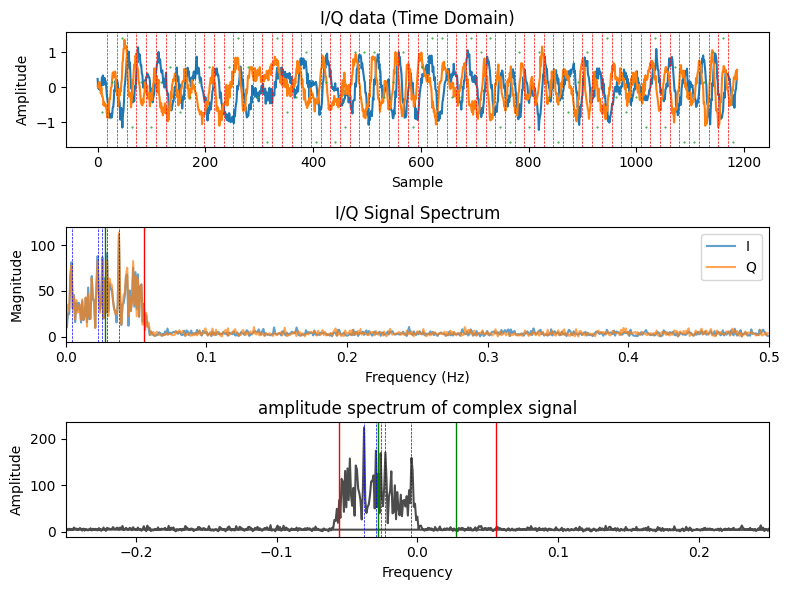

In [117]:
swa = symbol_width * EBDSC3rdDataset.SYMBOL_WIDTH_UNIT

# 参数设置
fs = 1  # 采样频率
passband = 0.5 / swa
stopband = 2 / swa
# 归一化频率
nyquist = fs / 2
passband_norm = passband / nyquist
stopband_norm = stopband / nyquist
# b, a = signal.butter(8, [passband_norm, stopband_norm], btype="band")
# b, a = signal.butter(8, passband, btype="high")
# iq_filtered = signal.filtfilt(b, a, IQ_data, axis=0)

iq_filtered = IQ_data

# 假设 iq_filtered 是一个包含 I 和 Q 分量的数组
# 将 IQ 数据转换为复信号
iq_complex = iq_filtered[:, 0] + 1j * iq_filtered[:, 1]

k = 5
show_freq(iq_complex, swa, code_sequence, k)

#### 下变频

如果接收到的信号是经过载波调制的，需要使用本地振荡器将其下变频到基带。下变频公式为：

$$
S_{\text{baseband}}(t) = S_{\text{received}}(t) \cdot e^{-j2\pi f_c t}
$$

其中，$ f_c $ 是载波频率。


In [118]:

# 计算 FFT 后的 mags 加权平均频率
def compute_weighted_freq(data_complex: np.ndarray, sample_rate: float = 1):
    """计算 FFT 后的 mags 加权平均频率

    Args:
        data_complex: 复数形式的 IQ 采样数据
        sample_rate: 采样率
    Returns:
        freq: 加权平均频率
    """
    n = len(data_complex)
    freqs = np.fft.fftfreq(n, d=1 / sample_rate)
    fft_values = np.fft.fft(data_complex)
    mags = np.abs(fft_values)
    # 过滤 mags > 50 的频率
    freqs = freqs[mags > 50]
    mags = mags[mags > 50]
    # 加权平均频率
    freq = np.sum(freqs * mags) / np.sum(mags)
    return freq

Top 5 frequency components: [-0.03787879 -0.02946128 -0.02272727 -0.02609428 -0.00420875], top_k_mags=array([224.64976993, 174.64876629, 170.93094702, 169.27069172,
       159.036627  ])
Carrier frequency: -0.03787878787878788


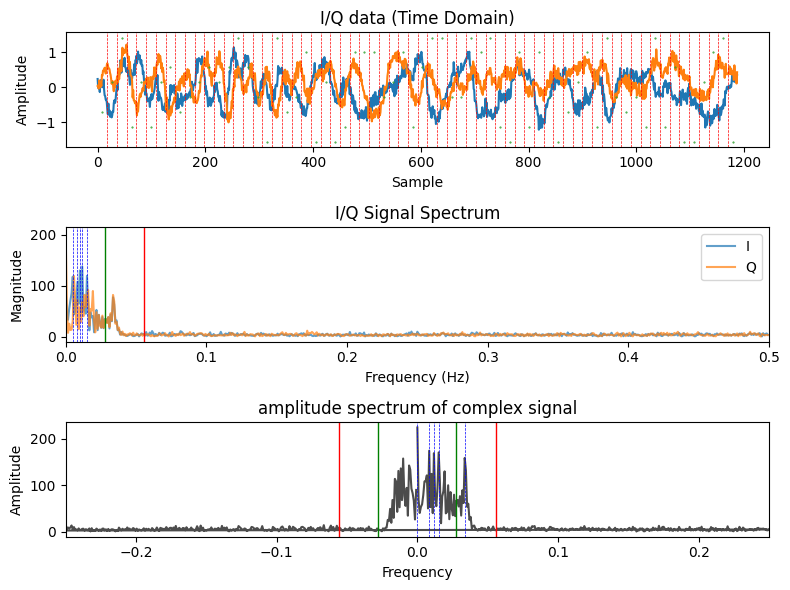

In [119]:
top_k_freq, top_k_mags = compute_topk_freqs(iq_complex, k, 1)
print(f"Top {k} frequency components: {top_k_freq}, {top_k_mags=}")

# 生成相干本地载波
sampling_rate = 1  # 如需实际采样率请替换
carrier_freq = top_k_freq[0] 
# # TODO 整体加权平均？
# carrier_freq = compute_weighted_freq(iq_complex, sampling_rate)
print(f"Carrier frequency: {carrier_freq}")

t = np.arange(len(iq_complex)) / sampling_rate
local_carrier = np.exp(-2j * np.pi * carrier_freq * t)

# 将 IQ 信号与本地载波相乘进行解调
demodulated_signal = iq_complex * local_carrier

show_freq(demodulated_signal, swa, code_sequence, k)

#### 滤波

使用低通滤波器（LPF）去除高频分量，仅保留基带信号。


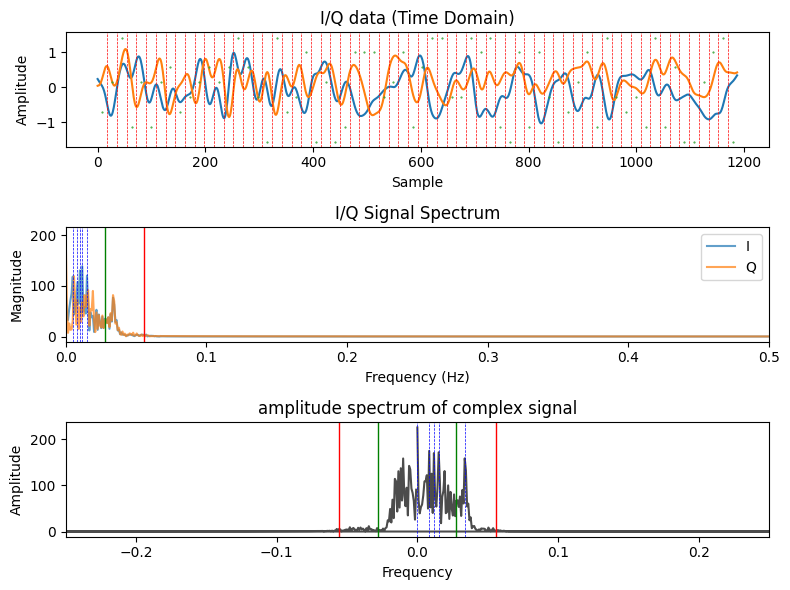

In [120]:
# f = 1/swa 滤波为基带信号
b, a = signal.butter(8, 1 * 1 / swa / nyquist, btype="low")
demodulated_signal_filtered = signal.filtfilt(b, a, demodulated_signal, axis=0)

# 提取解调后的 I/Q 信号

show_freq(demodulated_signal_filtered, swa, code_sequence, k)

if np.iscomplexobj(iq_filtered):
    iq_filtered = np.stack([iq_filtered.real, iq_filtered.imag], axis=-1)
code_sequence_filtered = code_sequence.astype(np.float32).copy()
code_sequence_filtered = (code_sequence_filtered - np.mean(code_sequence_filtered)) / np.std(code_sequence_filtered)


In [127]:
# 交互式调整载波频率

def plot_by_f(f):
    carrier_freq = f
    # print(f"Carrier frequency: {carrier_freq}")
    t = np.arange(len(iq_complex)) / sampling_rate
    local_carrier = np.exp(-2j * np.pi * carrier_freq * t)

    # 将 IQ 信号与本地载波相乘进行解调
    demodulated_signal = iq_complex * local_carrier
    
    b, a = signal.butter(8, 1 * 1 / swa / nyquist, btype="low")
    demodulated_signal_filtered = signal.filtfilt(b, a, demodulated_signal, axis=0)
    # 带通
    # passband_norm = passband / nyquist
    # stopband_norm = stopband / nyquist
    # b, a = signal.butter(8, [passband_norm, stopband_norm], btype="band")
    # demodulated_signal_filtered = signal.filtfilt(b, a, demodulated_signal, axis=0)

    show_freq(demodulated_signal_filtered, swa, code_sequence, k)

interact(
    plot_by_f, 
    f=widgets.FloatSlider(value=carrier_freq, min=-0.15, max=0.15, step=0.0001, description='Frequency:'),
    # passband=widgets.FloatSlider(value=passband, min=0.0, max=0.1, step=0.001, description='Passband:'),
    # stopband=widgets.FloatSlider(value=stopband, min=0.0, max=0.2, step=0.001, description='Stopband:')
)

interactive(children=(FloatSlider(value=-0.03787878787878788, description='Frequency:', max=0.15, min=-0.15, s…

<function __main__.plot_by_f(f)>

In [122]:
def plot_colored_constellation(IQ_data, code_sequence, symbol_width_absl, mod_type):
    """绘制按码字着色的星座图

    Args:
        IQ_data: IQ 采样数据，shape=(n,2)
        code_sequence: 码字序列
        symbol_width: 码元宽度
        mod_type: 调制类型
        unit: 采样率单位 (默认 20)
    """
    if np.iscomplexobj(IQ_data):
        IQ_data = np.stack([IQ_data.real, IQ_data.imag], axis=-1)

    # 计算每个码元的采样点数
    samples_per_symbol = int(symbol_width_absl)

    # 对每个码字进行着色
    unique_codes = np.unique(code_sequence)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_codes)))

    for code, color in zip(unique_codes, colors):
        # 找到当前码字的位置
        code_positions = np.where(code_sequence == code)[0]

        # 收集对应的 IQ 样本
        points = []
        for pos in code_positions:
            start = pos * samples_per_symbol
            end = start + samples_per_symbol
            # points.extend(IQ_data[start:end])
            if start+samples_per_symbol//2 < len(IQ_data):
                points.append(IQ_data[start+samples_per_symbol//2])
        points = np.array(points)

        # 绘制散点
        plt.scatter(points[:, 0], points[:, 1], c=[color], alpha=1, marker=".", label=f"Code {code}", s=5)
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
    # plt.legend()
    plt.axis("equal")

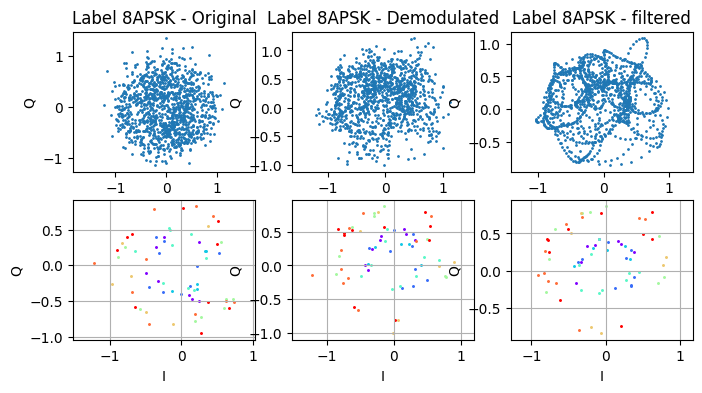

In [123]:
# 绘制星座图
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.scatter(IQ_data[:, 0], IQ_data[:, 1], s=1)
plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - Original")
plt.xlabel("I")
plt.ylabel("Q")
plt.axis("equal")


plt.subplot(2, 3, 2)
plt.scatter(np.real(demodulated_signal), np.imag(demodulated_signal), s=1)
plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - Demodulated")
plt.xlabel("I")
plt.ylabel("Q")
plt.axis("equal")

plt.subplot(2, 3, 3)
plt.scatter(np.real(demodulated_signal_filtered), np.imag(demodulated_signal_filtered), s=1)
plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - filtered")
plt.xlabel("I")
plt.ylabel("Q")
plt.axis("equal")

# TODO 只绘制采用点的星座图
plt.subplot(2, 3, 1+3)
plot_colored_constellation(IQ_data, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
plt.subplot(2, 3, 2+3)
plot_colored_constellation(demodulated_signal, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
plt.subplot(2, 3, 3+3)
plot_colored_constellation(demodulated_signal_filtered, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
plt.show()

In [124]:
# 交互式星座图
def plot_colored_constellation_interact(f):
    carrier_freq = f
    t = np.arange(len(iq_complex)) / sampling_rate
    local_carrier = np.exp(-2j * np.pi * carrier_freq * t)

    # 将 IQ 信号与本地载波相乘进行解调
    demodulated_signal = iq_complex * local_carrier

    # f = 1/swa 滤波为基带信号
    b, a = signal.butter(8, 1 * 1 / swa / nyquist, btype="low")
    demodulated_signal_filtered = signal.filtfilt(b, a, demodulated_signal, axis=0)

    # 绘制星座图
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 3, 1)
    plt.scatter(IQ_data[:, 0], IQ_data[:, 1], s=1)
    plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - Original")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")
    
    plt.subplot(2, 3, 2)
    plt.scatter(np.real(demodulated_signal), np.imag(demodulated_signal), s=1)
    plt.title(f" Demodulated f={carrier_freq:.5f}")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")

    plt.subplot(2, 3, 3)
    plt.scatter(np.real(demodulated_signal_filtered), np.imag(demodulated_signal_filtered), s=1)
    plt.title(f" filtered")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")

    # TODO 只绘制采用点的星座图
    plt.subplot(2, 3, 1+3)
    plot_colored_constellation(IQ_data, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
    plt.subplot(2, 3, 2+3)
    plot_colored_constellation(demodulated_signal, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
    plt.subplot(2, 3, 3+3)
    plot_colored_constellation(demodulated_signal_filtered, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
    # plt.legend()
    plt.show()
interact(plot_colored_constellation_interact, f=widgets.FloatSlider(value=carrier_freq, min=-0.2, max=0.2, step=0.0001, description='Frequency:', layout=widgets.Layout(width='1000px')))

interactive(children=(FloatSlider(value=-0.03787878787878788, description='Frequency:', layout=Layout(width='1…

<function __main__.plot_colored_constellation_interact(f)>

In [125]:
# 交互式星座图
def plot_colored_constellation_interact_2(f):
    carrier_freq = f
    t = np.arange(len(iq_complex)) / sampling_rate
    local_carrier = np.exp(-2j * np.pi * carrier_freq * t)

    # 将 IQ 信号与本地载波相乘进行解调
    demodulated_signal = iq_complex * local_carrier
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(np.real(demodulated_signal), np.imag(demodulated_signal), s=1)
    plt.title(f" Demodulated f={carrier_freq:.5f}")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    plt.subplot(1, 2, 2)
    plot_colored_constellation(demodulated_signal, code_sequence, swa, EBDSC3rdDataset.MOD_TYPE[mod_type])
    # plt.legend()
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.show()
interact(plot_colored_constellation_interact_2, f=widgets.FloatSlider(value=carrier_freq, min=-0.2, max=0.2, step=0.00005, description='Frequency:', layout=widgets.Layout(width='1000px')))

interactive(children=(FloatSlider(value=-0.03787878787878788, description='Frequency:', layout=Layout(width='1…

<function __main__.plot_colored_constellation_interact_2(f)>

In [126]:
# for i in range(10):
#     start = i * int(swa)
#     end = start + int(swa) 
#     s = slice(start, end)
#     plt.figure(figsize=(8, 2))
#     plt.subplot(1, 3, 1)
#     plt.scatter(IQ_data[s, 0], IQ_data[s, 1], s=1)
#     plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - Original")
#     plt.xlabel("I")
#     plt.ylabel("Q")
#     plt.axis("equal")


#     plt.subplot(1, 3, 2)
#     plt.scatter(np.real(demodulated_signal)[s], np.imag(demodulated_signal)[s], s=1)
#     plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - Demodulated")
#     plt.xlabel("I")
#     plt.ylabel("Q")
#     plt.axis("equal")

#     plt.subplot(1, 3, 3)
#     plt.scatter(np.real(demodulated_signal_filtered)[s], np.imag(demodulated_signal_filtered)[s], s=1)
#     plt.title(f"Label {EBDSC3rdDataset.MOD_TYPE[mod_type]} - filtered")
#     plt.xlabel("I")
#     plt.ylabel("Q")
#     plt.axis("equal")
#     plt.show()


## 测试集

测试集数量约 2.6W 个样本，包括若干不同调制类型、不同信号长度码元宽度、SNR 及多径的样本数据，也包含未知调制类型的信号样本（未知调制类型包括但不限于 256QAM、OFDM），针对已知调制类型的信号样本要求解析出其调制类型、码元宽度以及码序列，针对未知调制类型的信号只需要给出未知标签（这里统一为标签 11），不需要预测其码元宽度和码序列。

测试数据设置信号的采样率为 20MHz，数据格式为 csv 文件，其中第一二列分别为仿真 IQ 波形，数据格式如表 2 所示：

表 2 测试集数据样例


## 提交

注意：数据中可能存在少量数据错误或干扰，请选手自行处理。

1、提交说明

选手提交模型，在线上进行推理，选手模型需要生成一个.csv 格式的结果文件，编码为 UTF-8，第一行为表头，如下例：

```csv
file_name,modulation_type,symbol_width,code_sequence
00001.csv,1,0.1,1 2 3
00002.csv,2,0.1,0 1 1 0 0 1 0 0 0 1 0 1 1 0
00003.csv,3,0.45,1 1 0 0 1
00004.csv,11
00005.csv,7,0.45,1 0 0 0 0 1 0 1 1 0 0 0 0 1 2 0 1 0 3 4 5
...,...,...,...
```


```python
# 获取测试集文件夹路径，不可更改！
testpath = "../train_data/16APSK"

# 获取测试集文件列表
test_file_lst = [name for name in os.listdir(testpath) if name.endswith(".csv")]
test_file_lst = test_file_lst[:10]  # 为了方便展示，只取前10个文件

# 初始化结果文件，定义表头，注意逗号之间无空格
result = ["file_name,modulation_type,symbol_width,code_sequence"]

"""
读入测试集文件，调用模型进行预测。
以下预测方式仅为示例参考，实现方式是用循环读入每个文件，依次进行预测，选手可以根据自己模型的情况自行修改
"""
# 循环测试集文件列表对每个文件进行预测
for filename in test_file_lst:
    # 待预测文件路径
    filepath = os.path.join(testpath, filename)

    # 读入测试文件，这里的测试文件为无表头的两列信号值
    df = pd.read_csv(filepath)

    # 这里为模型加载的路径，可直接使用相对路径
    # model_path = r'模型在当前文件夹下的相对路径'

    """
    ┌ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ┐
    │加载模型，选手根据自己模型情况进行加载并进行多个任务的预测，在此不做展示│
    └ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ┘
    """

    # 以下三个需要预测指标分别指定了一个值代替预测值，选手需要根据自己模型进行实际的预测
    # 预测调制类型，数据类型为整型
    # 如果预测为未知类别（即类别 11），不需要提交其码元宽度和码序列。
    modulation_type = 11

    # 预测码元宽度，数据类型为浮点型
    symbol_width = 0.55

    # 预测码序列，数据类型为字符串，且序列内容为若干整数，数字之间用空格分隔
    code_sequence = "0 0 1 0"

    result.append("%s,%d,%f,%s" % (filename, modulation_type, symbol_width, code_sequence))

# 将预测结果保存到 result_save_path，保存方式可修改，但是注意保存路径不可更改！！！
result_save_path = "./result.csv"
with open(result_save_path, "w") as f:
    f.write("\n".join(result))

```
